# Project 3: Web APIs and Subreddit NLP Classifier

## Problem Statement

Technological advances have revolutionized the ways in which human communicate. It has infiltrated almost every aspect of our lives, and social media is one of the biggest recipients of its influence. With this rise, many people are now turning into social media as a source for rich and valuable information, and one of which is for personal financial advice. Today, many people are tech savvy and know how to research what they want to know before making a decision or seeking advice from advisors.

However, obtaining information from the right portals would be dependent on the nature of the portals, especially for users coming from different financial goals and conveying sensitive information in anonymity. 

With such, I aim to create a model that classifies two popular finance-related online communities on Reddit: r/povertyfinance and r/investing. Using our model, we aim to address the following problems: 

- Individuals: Which subreddit should I obtain information, seek advice from or share my experience, given my financial situation? 

- Financial Advisors: What topics would my existing or potential clients be interested about that I should study into it?

- Personal Finance Blogs / Websites: What topics are the community discussing about, and what kind of content can I share to improve engagements or visits?

## Executive Summary

Reddit, an American online community, has over 500 million registered users worldwide. It is broken up into more than a million communities known as “subreddits,” each of which covers a different topic. In this project, we have collected data via the official Reddit API for two popular subreddits:

**r/povertyfinance**: Financial advice, frugality tips, stories, opportunities, and general guidance for people who are struggling financially.

**r/investing**: Advice and opportunities for those actively participating in financial markets.

After removing duplicates and cleaning, we worked with 1890 samples of combined title and content. The samples are then split into training, validation and test dataset. We used two classification models, Naive-Bayes Multinomial and Logistic Regression, each coupled with different vectorizers, Count Vectorizer and TFIDF Vectorizer. The parameters of the vectorizers were optimized using GridSearchCV. We then compared the accuracy, precision and sensitivity scores across the different combination of models and vectorizers. The best performing model was then used to evaluate our test data.

Our final classifier model, Multinomial Naive Bayes with TFIDF Vectorizer,  was able to predict 97.4% of the posts in the test data accurately. It has a precision of 97.8% and sensitivity of 96.7%. This shows that our model was able to classify the posts rather well, which could be due to the difference in nature of the subreddits. However, misclassifications happened when words used were more generic in nature, such as the word 'bank' which in r/povertyfinance may refer to bank recommendations and in r/investing may refer to performance of banking sector. 

Our model found that:
* Topics in r/povertyfinance center around **saving up and restricting spending for the financially challenged**. This includes money-saving tips / frugality (e.g. eggs as part of meals, groceries), basic needs (e.g. dental services), insurance advice, paying debts, and living paycheck to paycheck. 
* Topics in r/investing center around **investing and making financial returns.** This includes stocks, market outlooks, discussions on companies, and earning potentials.


### Data dictionary
The data dictionary for the final dataset that was cleaned is shown below:

|Feature|Type|Description|
|---|---|---|
|subreddit|integer|1 represents r/investing, 0 represents r/povertyfinance| 
|alltext|object|Combined title and content of each in thread in the subreddits|

 
### Contents

1. Data Collection - Web Scraping
2. Data Cleaning & Exploratory Data Analysis
3. Modelling
    * Split Dataset into Train, Validation and Test
    * Classification Models
        * Naive Bayes
        * Logistic Regression
    * Summary of Scores
4. Model Evaluation on Test Data
5. Conclusion and Recommendations
    

In [1]:
#import libraries

import requests
import time
import numpy as np
import pandas as pd
import random
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## 1. Data Collection - Web Scraping

In [2]:
#scrapping function
def subreddit_scrap(url,filename):
    '''This function scraps subreddit posts from the specified url and 
    exports 1000 posts into a specified filename. '''
    
    after_id = None

    for counter in range(40):
        #first
        if after_id == None:
            current_url = url
            
        #subsequent pulls
        else:
            current_url = url + '?after=' + after_id
        
        #set user agent
        header = {'User-agent': 'DSI14 Bot 2.0'}
        
        #request subreddit
        res = requests.get(current_url, headers = header) 
        
        status = res.status_code
        
        #if status not 200 then break loop
        if status != 200:
            print('Status Error Code:', res.status_code)
            break
        
        else:
            print('Getting posts from:', current_url)
            
        current_dict = res.json()
        current_posts = [post['data'] for post in current_dict['data']['children']]
        
        # assign current posts to dataframe
        current_df = pd.DataFrame(current_posts)
        
        #if first loop, export to csv. else read previous posts csv, concatenate current posts, export
        if counter == 0:
            current_df.to_csv(filename, index = False)
            print('No. of posts exported to csv: ',str(len(current_posts)))
            
        else:
            prev_df = pd.read_csv(filename)
            all_df = pd.concat([prev_df, current_df], axis = 0)
            pd.DataFrame(all_df).to_csv(filename, index = False)
            print('No. of posts in csv: ',str(all_df.shape[0]))
       
        # update after id
        after_id = current_dict['data']['after']
        
        #generate sleep duration to look natural
        sleep_duration = random.randint(2,60)
        print('Sleeping time (sec): ',str(sleep_duration))
        time.sleep(sleep_duration)
        
    print(f'Completed: Scrapped {url} and exported to {filename}')

In [3]:
povertyfinance_url = 'https://www.reddit.com/r/povertyfinance.json'
investing_url = 'https://www.reddit.com/r/investing.json'

In [50]:
#povertyfinance_file = './datasets/povertyf_subreddit.csv'
#investing_file = './datasets/investing_subreddit.csv'

In [40]:
#scrap r/provertyfinance
#subreddit_scrap(povertyfinance_url,povertyfinance_file)

Getting posts from: https://www.reddit.com/r/povertyfinance.json
No. of posts exported to csv:  26
Sleeping time (sec):  14
Getting posts from: https://www.reddit.com/r/povertyfinance.json?after=t3_ghaxx5
No. of posts in csv:  51
Sleeping time (sec):  43
Getting posts from: https://www.reddit.com/r/povertyfinance.json?after=t3_ggivoq
No. of posts in csv:  76
Sleeping time (sec):  32
Getting posts from: https://www.reddit.com/r/povertyfinance.json?after=t3_gfy89n
No. of posts in csv:  101
Sleeping time (sec):  42
Getting posts from: https://www.reddit.com/r/povertyfinance.json?after=t3_gexria
No. of posts in csv:  126
Sleeping time (sec):  32
Getting posts from: https://www.reddit.com/r/povertyfinance.json?after=t3_gezlbc
No. of posts in csv:  151
Sleeping time (sec):  37
Getting posts from: https://www.reddit.com/r/povertyfinance.json?after=t3_ge74e4
No. of posts in csv:  176
Sleeping time (sec):  41
Getting posts from: https://www.reddit.com/r/povertyfinance.json?after=t3_gdegub
No. o

In [45]:
#scrap r/investing
#subreddit_scrap(investing_url,investing_file)

Getting posts from: https://www.reddit.com/r/investing.json
No. of posts exported to csv:  27
Sleeping time (sec):  46
Getting posts from: https://www.reddit.com/r/investing.json?after=t3_ghhfvy
No. of posts in csv:  52
Sleeping time (sec):  11
Getting posts from: https://www.reddit.com/r/investing.json?after=t3_gh1nfq
No. of posts in csv:  77
Sleeping time (sec):  2
Getting posts from: https://www.reddit.com/r/investing.json?after=t3_gguij0
No. of posts in csv:  102
Sleeping time (sec):  12
Getting posts from: https://www.reddit.com/r/investing.json?after=t3_ggt2dt
No. of posts in csv:  127
Sleeping time (sec):  12
Getting posts from: https://www.reddit.com/r/investing.json?after=t3_gg6120
No. of posts in csv:  152
Sleeping time (sec):  8
Getting posts from: https://www.reddit.com/r/investing.json?after=t3_gfweu3
No. of posts in csv:  177
Sleeping time (sec):  33
Getting posts from: https://www.reddit.com/r/investing.json?after=t3_gg3p0e
No. of posts in csv:  202
Sleeping time (sec): 

## 2. Data Cleaning & Exploratory Data Analysis

In [4]:
#importing csv
pfin_raw_df = pd.read_csv('./datasets/povertyf_subreddit.csv')
investing_raw_df = pd.read_csv('./datasets/investing_subreddit.csv')

In [5]:
pfin_raw_df.shape

(992, 110)

In [6]:
investing_raw_df.shape

(1003, 101)

In [7]:
pfin_raw_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,post_hint,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,preview,all_awardings,awarders,media_only,link_flair_template_id,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,crosspost_parent_list,crosspost_parent,poll_data,author_cakeday
0,NaN,povertyfinance,I'm seeing a *ton* of bad information being po...,t2_bxvkg,False,NaN,1,False,"CARES Act FAQ -- stimulus checks, unemployment...",[],r/povertyfinance,False,6,NaN,0,NaN,False,t3_fs0io5,False,light,1.00,NaN,public,280,2,{},NaN,NaN,False,[],NaN,False,False,NaN,{},COVID-19,False,280,NaN,False,self,1585607094.0,NaN,[],{'gid_2': 1},self,NaN,True,NaN,1.585635e+09,text,6,NaN,NaN,text,self.povertyfinance,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,{'images': [{'source': {'url': 'https://extern...,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,5bfb9d16-66d4-11ea-99c6-0e813deb6267,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_hcycg,NaN,NaN,#014980,fs0io5,True,NaN,CWSwapigans,NaN,194,True,all_ads,False,[],False,NaN,/r/povertyfinance/comments/fs0io5/cares_act_fa...,all_ads,True,https://www.reddit.com/r/povertyfinance/commen...,305170,1.585606e+09,0,NaN,False,NaN,NaN,NaN,NaN
1,NaN,povertyfinance,"I don't know about ya'll, but up until recentl...",t2_12etc8,False,NaN,0,False,Invest in long term oral health!,[],r/povertyfinance,False,6,NaN,0,NaN,False,t3_ghho7r,False,dark,0.98,NaN,public,686,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},Misc Advice,False,686,NaN,False,self,False,NaN,[],{},NaN,NaN,True,NaN,1.589204e+09,text,6,NaN,NaN,text,self.povertyfinance,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,[],[],False,72d88b32-68cf-11ea-b1b1-0efae3108b5b,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_hcycg,NaN,NaN,#bbbdbf,ghho7r,True,NaN,Anilxe,NaN,129,True,all_ads,False,[],False,NaN,/r/povertyfinance/comments/ghho7r/invest_in_lo...,all_ads,False,https://www.reddit.com/r/povertyfinance/commen...,305170,1.589175e+09,0,NaN,False,NaN,NaN,NaN,NaN
2,NaN,povertyfinance,I work a restaurant job that has been open dur...,t2_2e6rbeso,False,NaN,0,False,How are you supposed to shelter in place if yo...,[],r/povertyfinance,False,6,NaN,0,NaN,False,t3_gh1an2,False,light,0.97,NaN,public,2067,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},Income/Employement/Aid,False,2067,NaN,False,self,False,NaN,[],{},NaN,NaN,True,NaN,1.589145e+09,text,6,NaN,NaN,text,self.povertyfinance,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,[],[],False,6b66411e-68cf-11ea-8232-0ed05c81a0f9,False,False,True,NaN,[],False,NaN,NaN,NaN,t5_hcycg,NaN,NaN,#94e044,gh1an2,True,NaN,poverty_with_love,NaN,237,True,all_ads,False,[],False,NaN,/r/povertyf

In [8]:
investing_raw_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
0,NaN,investing,"Alright everyone, it looks like we had pretty ...",t2_p8vmm,False,NaN,0,False,Formal posting guidelines for political topics...,[],r/investing,False,6,NaN,0,False,t3_cyee69,False,dark,0.95,NaN,public,274,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,274,NaN,False,NaN,1567518369.0,NaN,[],{},NaN,True,NaN,1.567395e+09,text,6,NaN,NaN,text,self.investing,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,True,False,False,False,False,[],[],False,False,False,True,NaN,[],False,NaN,NaN,NaN,t5_2qhhq,NaN,NaN,NaN,cyee69,True,NaN,MasterCookSwag,NaN,0,True,all_ads,False,[],False,NaN,/r/investing/comments/cyee69/formal_posting_gu...,all_ads,True,https://www.reddit.com/r/investing/comments/cy...,1041354,1.567366e+09,1,NaN,False
1,NaN,investing,"If your question is ""I have $10,000, what do I...",t2_6l4z3,False,NaN,0,False,Daily Advice Thread - All basic help or advice...,[],r/investing,False,6,NaN,0,False,t3_ghmgt7,False,dark,0.73,NaN,public,6,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,6,NaN,True,NaN,False,NaN,[],{},NaN,True,NaN,1.589228e+09,text,6,NaN,NaN,text,self.investing,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,new,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,moderator,t5_2qhhq,NaN,NaN,NaN,ghmgt7,True,NaN,AutoModerator,NaN,50,False,all_ads,False,[],False,NaN,/r/investing/comments/ghmgt7/daily_advice_thre...,all_ads,True,https://www.reddit.com/r/investing/comments/gh...,1041354,1.589199e+09,0,NaN,False
2,NaN,investing,In 2019 investors pulled their money out of th...,t2_zvs47rd,False,NaN,0,False,A record 1.1 Trillion left stocks 1 year befor...,[],r/investing,False,6,NaN,0,False,t3_ghew38,False,dark,0.91,NaN,public,1675,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,1675,NaN,False,NaN,1589171325.0,NaN,[],{},NaN,True,NaN,1.589192e+09,text,6,NaN,NaN,text,self.investing,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qhhq,NaN,NaN,NaN,ghew38,True,NaN,speaknovel,NaN,222,True,all_ads,False,[],False,NaN,/r/investing/comments/ghew38/a_record_11_trill...,all_ads,False,https://www.reddit.com/r/investing/comments/gh...,1041354,1.589164e+09,0,NaN,False
3,NaN,investing,Investors pulled $16.2 billion from stocks in ...,t2_gaprz,False,NaN,0,False,Investors exit stocks at fastest rate since Ma...,[],r/investing,False,6,NaN,0,False,t3_ghdyps,False,dark,0.91,NaN,public,603,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,603,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589189e+09,text,6,NaN,NaN,text,self.investing,True

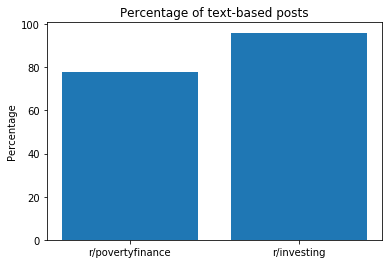

In [9]:
# percentage of text posts
pfin_rows = pfin_raw_df.shape[0]
investing_rows = investing_raw_df.shape[0]

pfin_text_perc = pfin_raw_df['selftext'].notnull().sum()/pfin_rows *100
investing_text_perc = investing_raw_df['selftext'].notnull().sum()/investing_rows *100

plt.bar(['r/povertyfinance','r/investing'], [pfin_text_perc,investing_text_perc])
plt.title('Percentage of text-based posts')
plt.ylabel('Percentage');

**Observations**: There is a higher percentage of text-based posts in r/investing than r/povertyfinance. This is likely due to more questions asked in the title rather than in the posts.

In [10]:
#create mask to remove null values
pfin_mask = pfin_raw_df['selftext'].notnull()
investing_mask = investing_raw_df['selftext'].notnull()

#instantiate basic count vectorizer
cvec = CountVectorizer(stop_words='english',
                       ngram_range=(2,3),
                      max_features = 500)

In [11]:
#apply count Vectorizer
cvec_pfin = cvec.fit_transform(pfin_raw_df[pfin_mask]['selftext'])
cvec_investing = cvec.fit_transform(investing_raw_df[investing_mask]['selftext'])

In [12]:
#convert sparse matrix to dataframe and transpose
cvec_pfin_df = pd.DataFrame(data = cvec_pfin.toarray(),
                           columns = cvec.get_feature_names())
cvec_investing_df = pd.DataFrame(data = cvec_investing.toarray(),
                           columns = cvec.get_feature_names())

#sum counts and get top 30 words 
cvec_pfin_top30 = cvec_pfin_df.sum().sort_values(ascending = False)[:30]
cvec_investing_top30 = cvec_investing_df.sum().sort_values(ascending = False)[:30]

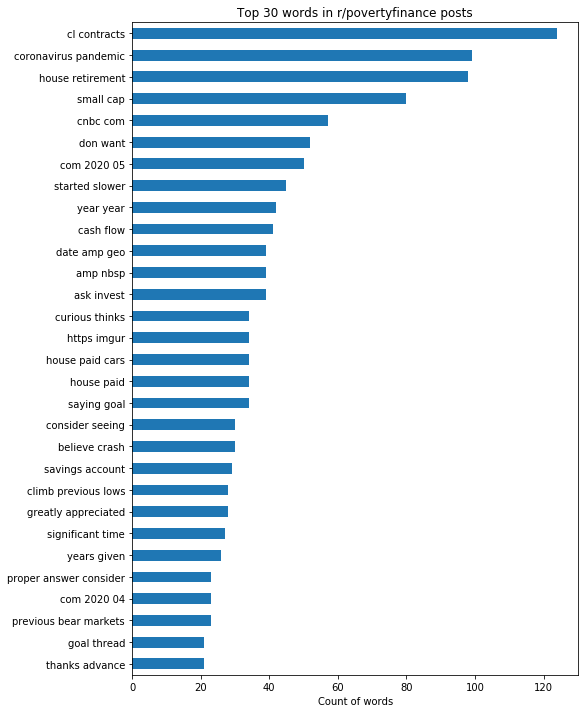

In [13]:
#plot top 30 words in r/povertyfinance posts
plt.figure(figsize = (8,12))
cvec_pfin_top30.plot.barh().invert_yaxis()
plt.title('Top 30 words in r/povertyfinance posts')
plt.xlabel('Count of words');

**Observations** : r/povertyfinance has a lot of links sharing news articles, and images  as words such as 'cnbc com', 'https imgur' appear in the top 30 words. Other than that, there are also Unicode character codes such as amp nbsp. These will be removed during preprocessing later. 

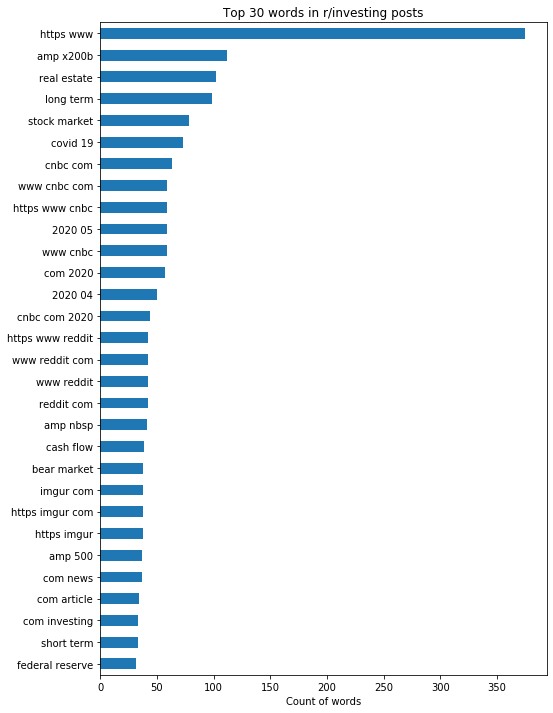

In [14]:
#plot top 30 words in r/investing posts
plt.figure(figsize = (8,12))
cvec_investing_top30.plot.barh().invert_yaxis()
plt.title('Top 30 words in r/investing posts')
plt.xlabel('Count of words');

**Observations** : r/investing has a lot of links sharing news articles, other reddit posts, and images as many words such as 'https www', 'cnbc com', 'imgur com' appear in the top 30 words. Other than that, there are also Unicode character codes such as ampx200b, amp 500. These will be removed during preprocessing later. 

In [15]:
#fill empty selftext with empty string
pfin_raw_df['selftext'].fillna('',inplace=True)
investing_raw_df['selftext'].fillna('',inplace=True)

#add in new column for length of selftext/post and title
pfin_raw_df['post_length'] = [0 if post == '' else len(post) for post in pfin_raw_df['selftext']]
pfin_raw_df['title_length'] = [0 if title == '' else len(title) for title in pfin_raw_df['title']]

investing_raw_df['post_length'] = [0 if post == '' else len(post) for post in investing_raw_df['selftext']]
investing_raw_df['title_length'] = [0 if title == '' else len(title) for title in investing_raw_df['title']]


In [16]:
pfin_raw_df[['post_length','title_length']].describe().T

,count,mean,std,min,25%,50%,75%,max
post_length,992.0,664.338710,875.525823,0.0,98.75,457.0,884.5,9412.0
title_length,992.0,69.646169,52.670259,4.0,34.00,55.0,86.0,304.0


In [17]:
investing_raw_df[['post_length','title_length']].describe().T

,count,mean,std,min,25%,50%,75%,max
post_length,1003.0,792.921236,1663.515054,0.0,225.5,446.0,853.0,39428.0
title_length,1003.0,57.942173,36.925488,2.0,31.5,51.0,75.0,280.0


In [18]:
# function to plot histogram to look at distributions
def subplot_histogram(dataframe, list_of_columns):
    '''This function creates subplots of histograms by passing in a dataframe and list of columns to plot'''
    nrows = int(np.ceil(len(list_of_columns)/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (20,nrows*6)) 
    ax = ax.ravel()
    for i, column in enumerate(list_of_columns): 
        ax[i].hist(dataframe[column],ec='white')
        if dataframe['subreddit'][0] == 'povertyfinance':
            ax[i].set_title(f'r/povertyfinance {column} distribution', fontsize = 12)
        if dataframe['subreddit'][0] == 'investing':
            ax[i].set_title(f'r/investing  {column} distribution', fontsize = 12)
        ax[i].set_xlabel('Length',fontsize = 8)
        ax[i].set_ylabel('Counts',fontsize = 8)
        ax[i].axvline(dataframe[column].mean(), color='g', linestyle='dashed', linewidth=2, label='Mean')
        ax[i].axvline(dataframe[column].median(), color='r', linestyle='dashed', linewidth=2, label='Median')
        ax[i].legend()
    plt.tight_layout()
    plt.show()

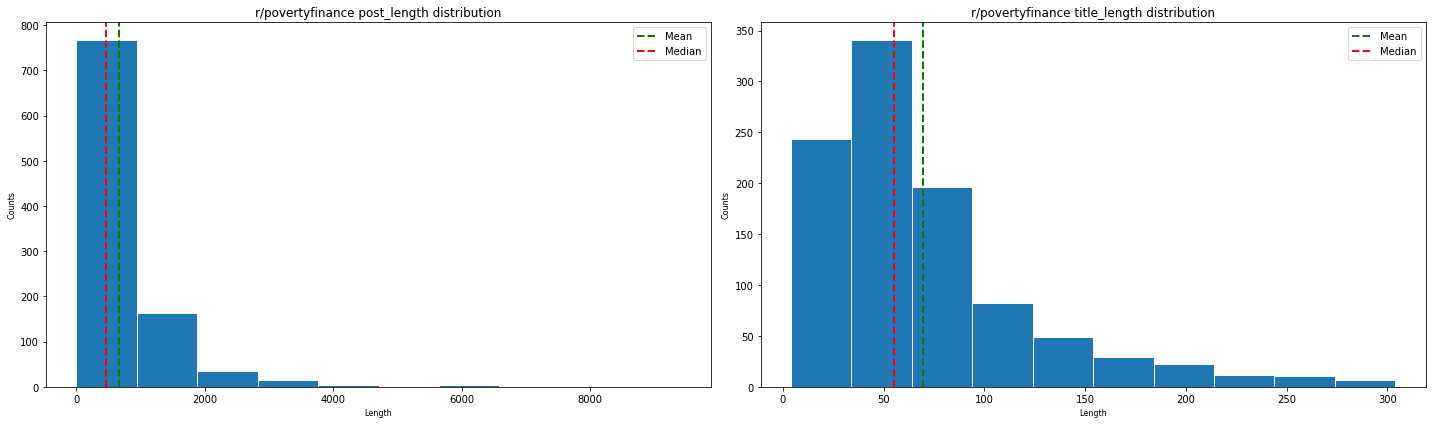

In [19]:
# length of posts and titles
columns = ['post_length','title_length']
subplot_histogram(pfin_raw_df,columns)

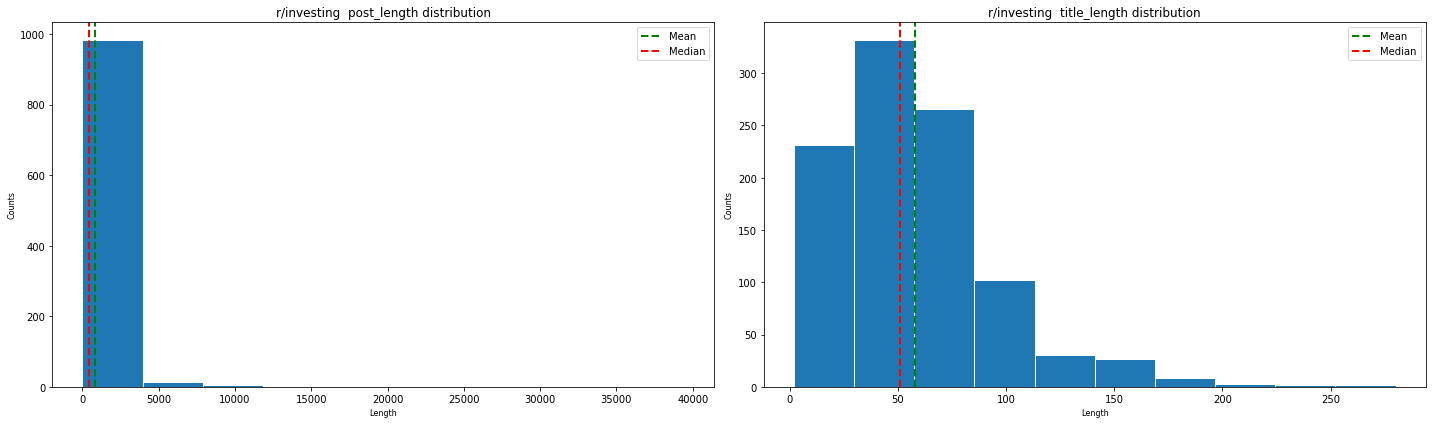

In [20]:
subplot_histogram(investing_raw_df,columns)

**Observations**:

Both reddits have similar averages in post lengths. However, r/investing has a larger range of post lengths and higher standard deviation, indicating that it has more longer posts as compared to r/povertyfinance. This may result in more vocabulary for r/investing. 

Both reddits have almost similar distributions in title lengths. However, r/povertyfinance has higher mean and standard deviation in title length, indicating that their titles are longer. As seen in our previous chart on percentage of text-based posts which is lower in r/povertyfinance, it further supports our hypothesis that content/question is primarily in the title section.

With such, we will engineer a column later to incorporate both title and post text.

### Selecting relevant columns

In [21]:
# r/povertyfinance: getting only relevant columns

cols = ['subreddit','selftext','title']

pfin_df = pd.DataFrame()

for col in cols:
    pfin_df[col] = pfin_raw_df[col]
    
pfin_df.head()

,subreddit,selftext,title
0,povertyfinance,I'm seeing a *ton* of bad information being po...,"CARES Act FAQ -- stimulus checks, unemployment..."
1,povertyfinance,"I don't know about ya'll, but up until recentl...",Invest in long term oral health!
2,povertyfinance,I work a restaurant job that has been open dur...,How are you supposed to shelter in place if yo...
3,povertyfinance,,"I have no health insurance, but in the process..."
4,povertyfinance,"Hi everyone, I'm on mobile so apologies in adv...",I can't find the courage to make any large pur...


In [22]:
# r/investing: getting only relevant columns

cols = ['subreddit','selftext','title']

investing_df = pd.DataFrame()

for col in cols:
    investing_df[col] = investing_raw_df[col]

investing_df.head()

,subreddit,selftext,title
0,investing,"Alright everyone, it looks like we had pretty ...",Formal posting guidelines for political topics...
1,investing,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...
2,investing,In 2019 investors pulled their money out of th...,A record 1.1 Trillion left stocks 1 year befor...
3,investing,Investors pulled $16.2 billion from stocks in ...,Investors exit stocks at fastest rate since Ma...
4,investing,Uhh what do I do? Im long AMC. Assuming the ta...,Amazon is considering an AMC takeover


### Checking null values

In [23]:
pfin_df.isnull().sum().sort_values(ascending=False)

title        0
selftext     0
subreddit    0
dtype: int64

In [24]:
investing_df.isnull().sum().sort_values(ascending=False)

title        0
selftext     0
subreddit    0
dtype: int64

### Engineering new column: alltext

In [25]:
# combine title and selftext into alltext for r/povertyfinance.
pfin_df['alltext'] = pfin_df['title'] + ' ' + pfin_df['selftext']
pfin_df.head()

,subreddit,selftext,title,alltext
0,povertyfinance,I'm seeing a *ton* of bad information being po...,"CARES Act FAQ -- stimulus checks, unemployment...","CARES Act FAQ -- stimulus checks, unemployment..."
1,povertyfinance,"I don't know about ya'll, but up until recentl...",Invest in long term oral health!,Invest in long term oral health! I don't know ...
2,povertyfinance,I work a restaurant job that has been open dur...,How are you supposed to shelter in place if yo...,How are you supposed to shelter in place if yo...
3,povertyfinance,,"I have no health insurance, but in the process...","I have no health insurance, but in the process..."
4,povertyfinance,"Hi everyone, I'm on mobile so apologies in adv...",I can't find the courage to make any large pur...,I can't find the courage to make any large pur...


In [26]:
# combine title and selftext into alltext for r/investing.
investing_df['alltext'] = investing_df['title'] + ' ' + investing_df['selftext']
investing_df.head()

,subreddit,selftext,title,alltext
0,investing,"Alright everyone, it looks like we had pretty ...",Formal posting guidelines for political topics...,Formal posting guidelines for political topics...
1,investing,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...,Daily Advice Thread - All basic help or advice...
2,investing,In 2019 investors pulled their money out of th...,A record 1.1 Trillion left stocks 1 year befor...,A record 1.1 Trillion left stocks 1 year befor...
3,investing,Investors pulled $16.2 billion from stocks in ...,Investors exit stocks at fastest rate since Ma...,Investors exit stocks at fastest rate since Ma...
4,investing,Uhh what do I do? Im long AMC. Assuming the ta...,Amazon is considering an AMC takeover,Amazon is considering an AMC takeover Uhh what...


In [27]:
#check shape before dropping duplicates in alltext
pfin_df.shape

(992, 4)

In [28]:
#drop duplicates in alltext
pfin_df.drop_duplicates(subset='alltext', keep='first', inplace=True)

In [29]:
#check shape after dropping
pfin_df.shape

(992, 4)

In [30]:
#check shape before dropping duplicates in alltext
investing_df.shape

(1003, 4)

In [31]:
#drop duplicates in alltext
investing_df.drop_duplicates(subset='alltext', keep='first', inplace=True)

In [32]:
#check shape after dropping
investing_df.shape

(898, 4)

### Lemmatizing and cleaning alltext

Steps involved:
* Removing links
* Removing non-letters
* Convert to lower case
* Tokenizing
* Removing stopwords
* Lemmatizing


In [33]:
def alltext_process(dataframe,column):
    '''Function to convert a raw text by removing http weblinks and new lines'''
    
    # Remove links.
    dataframe[column] = dataframe[column].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)    
    
    # Remove non-letters.
    dataframe[column] = dataframe[column].replace(r'[^a-zA-Z]', ' ',regex=True)
    
    # Convert to lower case.
    dataframe[column] = dataframe[column].apply(lambda text: text.lower())
    
    # tokenizing / split into individual words
    dataframe[column] = dataframe[column].apply(lambda text: text.split())
    
    # remove stopwords
    stops = set(stopwords.words('english'))
    dataframe[column] = dataframe[column].apply(lambda text: [w for w in text if w not in stops])
    
    # lemmatize
    # instantiate
    lemmatizer = WordNetLemmatizer()
    dataframe[column] = dataframe[column].apply(lambda text: [lemmatizer.lemmatize(w) for w in text])
    
    # join the words back into one string separated by space and return the result.
    dataframe[column] = dataframe[column].apply(lambda w: ' '.join(w))
    
    return dataframe

In [34]:
#apply function to dataframes
pfin_clean_df = alltext_process(pfin_df,'alltext')
investing_clean_df =alltext_process(investing_df,'alltext')

### Merge dataframes

In [35]:
# getting alltext and subreddit columns
pfin_final_df = pfin_clean_df[['alltext','subreddit']]
investing_final_df = investing_clean_df[['alltext','subreddit']]
print(pfin_final_df.shape)
print(investing_final_df.shape)

(992, 2)
(898, 2)


In [36]:
# merge
combined_df = pd.concat([pfin_final_df, investing_final_df])
print(combined_df.shape)

(1890, 2)


In [37]:
# reset index
combined_df = combined_df.reset_index(drop=True)

In [38]:
# map subreddit column
combined_df['subreddit'] = combined_df['subreddit'].map({'povertyfinance':0,'investing':1})

In [39]:
combined_df.head()

,alltext,subreddit
0,care act faq stimulus check unemployment seein...,0
1,invest long term oral health know ya recently ...,0
2,supposed shelter place cannot afford stay home...,0
3,health insurance process applying coverage fin...,0
4,find courage make large purchase hi everyone m...,0


In [40]:
#Baseline proportion
baseline = combined_df['subreddit'].value_counts(normalize=True)
baseline

0    0.524868
1    0.475132
Name: subreddit, dtype: float64

In [40]:
#export
#combined_df.to_csv('./datasets/combined_df_cleaned.csv')

## 3. Modelling

To classify the r/povertyfinance and r/investing, the modelling process will involve:

* Splitting dataset into Train, Validation and Test
* Text Vectorization: Count Vectorizer or TFIDF Vectorizer
* Classification Models: Multinomial Naive Bayes or Logistic Regression, and compare their performance when coupled optimized parameters of the different vectorizers.

### 3.1 Split Dataset into Train, Validation and Test

In [41]:
# X feature and y predictor
X = combined_df['alltext']
y = combined_df['subreddit']

In [42]:
# Split into train set and test set to evaluate final model.
X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,
                                                             test_size = 0.2,
                                                             random_state=42,
                                                             shuffle=True,
                                                             stratify=y)

In [43]:
# check shape of X_train_val
X_train_val.shape

(1512,)

In [44]:
# check shape of y_train_val
y_train_val.shape

(1512,)

In [45]:
# check shape of X_alltest
X_test.shape

(378,)

In [46]:
#check shape of y_test
y_test.shape

(378,)

In [47]:
# Split X_train_val into train and val for validation set
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,
                                               test_size = 0.2, 
                                               random_state = 42, 
                                               shuffle = True)


In [48]:
X_train.shape

(1209,)

In [49]:
X_val.shape

(303,)

In [50]:
X_test.shape

(378,)

In [51]:
#checking that all the splitted datasets has been stratified
y_train.value_counts(normalize=True)

0    0.525227
1    0.474773
Name: subreddit, dtype: float64

In [52]:
y_val.value_counts(normalize=True)

0    0.524752
1    0.475248
Name: subreddit, dtype: float64

In [53]:
y_test.value_counts(normalize = True)

0    0.52381
1    0.47619
Name: subreddit, dtype: float64

### 3.2 Classification Models

The two models selected are Naive Bayes and Logistic Regression. On each model, I will use
* GridSearchCV to optimize parameters of CountVectorizer
* GridSearchCV to optimize parameters of TfidfVectorizer

In [54]:
#empty list to append so we can create a summary table later
model_type = []
vectorizer_type = []
parameters = []
accuracy_train = []
accuracy_val = []
precision_val = []
sensitivity_val = []
roc_val = []

In [55]:
def evaluate_model(pipe,param):
    '''This function takes in a Pipeline and its parameters. It prints the best score, best parameters,
    accuracy on training data, accuracy on validation data, precision score of model, sensitivity score of model,
    and confusion matrix. It appends all the printed items into a list that can be converted to dataframe later.'''
    gs = GridSearchCV(pipe,param, cv=10)
    gs.fit(X_train,y_train)
    
    #Best score from GridSearchCV
    best_score = gs.best_score_
    print(f'Best Score: {best_score}')
      
    #Best Parameters from GridSearchCV
    best_params = gs.best_params_
    print(f'Best Params: {best_params}')
    
    #Best model from GridSearchCV
    best_model = gs.best_estimator_ 
    
    #Best model score on train data
    train_score = best_model.score(X_train, y_train)
    print(f'Accuracy of training data: {train_score}')
    
    #Best model score on validation data
    val_score = best_model.score(X_val,y_val)
    print(f'Accuracy of validation data: {val_score}')
    
    #Make predictions using best model on validation data
    predictions = best_model.predict(X_val)
    
    #Create confusion matrix
    cm = confusion_matrix(y_val,predictions)
    tn, fp, fn, tp = cm.ravel()
    
    #Precision score
    precision = tp/(tp+fp)
    print(f'Precision score of the model: {precision}')
    
    #Sensitivity / Recall
    sensitivity = tp/(tp+fn)
    print(f'Sensitivity score of the model: {sensitivity}')
    
    #ROC and AUC score
    roc = roc_auc_score(y_val,predictions)
    print(f'ROC AUC Score: {roc}')
    
    #append all to list to convert to summary dataframe    
    model_name = list(pipe.named_steps.keys())[1]
    vectorizer_name = list(pipe.named_steps.keys())[0]
    
    model_type.append(model_name)
    vectorizer_type.append(vectorizer_name)
    parameters.append(best_params)
    accuracy_train.append(round(train_score,3))
    accuracy_val.append(round(val_score,3))
    precision_val.append(round(precision,3))
    sensitivity_val.append(round(sensitivity,3))    
    roc_val.append(round(roc,3))
    
    # confusion matrix to dataframe
    cm_df = pd.DataFrame(cm, columns= ['Predict r/povertyfinance', 'Predict r/investing'], 
                         index=['Actual r/povertyfinance', 'Actual r/investing']) 
    
    return cm_df

#### 4.2.1 Naive Bayes

##### Optimized CountVectorizer using GridSearchCV


In [56]:
#pipeline for cvec and nb
pipe_c_n = Pipeline([
    ('cvec',CountVectorizer()),
    ('nb',MultinomialNB())
])


#pipeline params for cvec
pipe_c_n_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.9,0.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'cvec__stop_words' : ['english']

}

#run gridsearchCV
evaluate_model(pipe_c_n,pipe_c_n_params)

Best Score: 0.9644283746556475
Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}
Accuracy of training data: 0.9826302729528535
Accuracy of validation data: 0.9702970297029703
Precision score of the model: 0.972027972027972
Sensitivity score of the model: 0.9652777777777778
ROC AUC Score: 0.9700602725366876


,Predict r/povertyfinance,Predict r/investing
Actual r/povertyfinance,155,4
Actual r/investing,5,139


##### Optimized TfidfVectorizer using GridSearchCV

In [57]:
#pipeline for tvec and nb
pipe_t_n = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('nb',MultinomialNB())
])

#pipeline parameters for tvec
pipe_t_n_params = {
    'tvec__max_features': [2000,3000,4000,5000],
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.9,0.95],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)],
    'tvec__stop_words' : ['english']
}

#run gridseachCV
evaluate_model(pipe_t_n,pipe_t_n_params)

Best Score: 0.9644283746556475
Best Params: {'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Accuracy of training data: 0.9826302729528535
Accuracy of validation data: 0.9702970297029703
Precision score of the model: 0.9655172413793104
Sensitivity score of the model: 0.9722222222222222
ROC AUC Score: 0.9703878406708596


,Predict r/povertyfinance,Predict r/investing
Actual r/povertyfinance,154,5
Actual r/investing,4,140


#### 4.2.2 Logistic Regression

##### Optimized CountVectorizer using GridSearchCV


In [58]:
#pipeline set up for cvec and lr
pipe_c_l = Pipeline([ 
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression()) 
])

#pipeline params for cvec
pipe_c_l_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.9,0.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'cvec__stop_words' : ['english']

}

#run gridsearchCV
evaluate_model(pipe_c_l,pipe_c_l_params)

Best Score: 0.9437465564738293
Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}
Accuracy of training data: 0.9983457402812241
Accuracy of validation data: 0.9372937293729373
Precision score of the model: 0.9496402877697842
Sensitivity score of the model: 0.9166666666666666
ROC AUC Score: 0.9363207547169811


,Predict r/povertyfinance,Predict r/investing
Actual r/povertyfinance,152,7
Actual r/investing,12,132


##### Optimized TfidfVectorizer using GridSearchCV

In [59]:
#pipeline for tvec and lr
pipe_t_l = Pipeline([ 
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression()) 
])

#pipeline parameters for tvec
pipe_t_l_params = {
    'tvec__max_features': [2000,3000,4000,5000],
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.9,0.95],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)],
    'tvec__stop_words' : ['english']

}

#run gridseachCV
evaluate_model(pipe_t_l,pipe_t_l_params)

Best Score: 0.9611225895316805
Best Params: {'tvec__max_df': 0.9, 'tvec__max_features': 4000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}
Accuracy of training data: 0.9884201819685691
Accuracy of validation data: 0.9636963696369637
Precision score of the model: 0.965034965034965
Sensitivity score of the model: 0.9583333333333334
ROC AUC Score: 0.9634433962264152


,Predict r/povertyfinance,Predict r/investing
Actual r/povertyfinance,154,5
Actual r/investing,6,138


### 3.3 Summary of Scores

In [62]:
#creating summary of scores in a dataframe
summary_scores = pd.DataFrame({'model': model_type, 'vectorizer':vectorizer_type,'parameters':parameters, 'training accuracy':accuracy_train, 
                                  'validation accuracy':accuracy_val, 'precision': precision_val, 'sensitivity':sensitivity_val, 'roc auc scores':roc_val})

#show full text in cell
pd.set_option('display.max_colwidth', None)

In [63]:
#renaming values in the summary_score dataframe
model_names = {'nb':'MultinomialNB','lr':'Logistic Regression'}
vectorizer_names = {'cvec':'CountVectorizer','tvec':'TfidfVectorizer'}
summary_scores['model'].replace(model_names,inplace=True)
summary_scores['vectorizer'].replace(vectorizer_names,inplace=True)

#convert parameters cell value to str
summary_scores['parameters'] = summary_scores['parameters'].map(lambda x: str(x))

summary_scores

,model,vectorizer,parameters,training accuracy,validation accuracy,precision,sensitivity,roc auc scores
0,MultinomialNB,CountVectorizer,"{'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}",0.983,0.970,0.972,0.965,0.970
1,MultinomialNB,TfidfVectorizer,"{'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}",0.983,0.970,0.966,0.972,0.970
2,Logistic Regression,CountVectorizer,"{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}",0.998,0.937,0.950,0.917,0.936
3,Logistic Regression,TfidfVectorizer,"{'tvec__max_df': 0.9, 'tvec__max_features': 4000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}",0.988,0.964,0.965,0.958,0.963


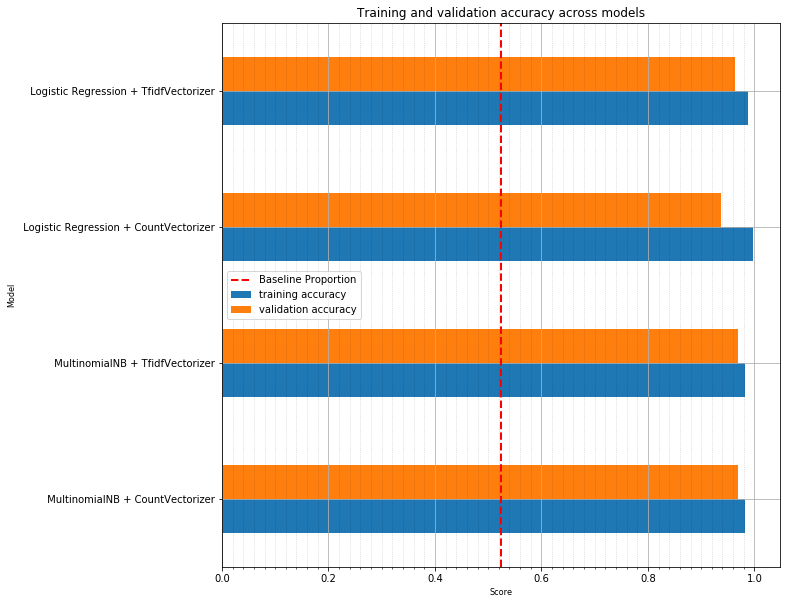

In [64]:
#baseline accuracy
baseline = combined_df['subreddit'].value_counts(normalize=True)[0]

#yticklabels
yticklabels = []
for _ in range(4):
    yticklabels.append(f" {summary_scores['model'][_]} + {summary_scores['vectorizer'][_]}")

#plot barchart
ax = summary_scores[['training accuracy','validation accuracy']].plot.barh(figsize = (10,10))
ax.set_title('Training and validation accuracy across models', fontsize = 12)
ax.set_xlabel('Score',fontsize = 8)
ax.set_ylabel('Model',fontsize = 8)
ax.axvline(baseline, color='r', linestyle='dashed', linewidth=2, label='Baseline Proportion')
ax.legend(loc = 'center left')
ax.set_xticks((np.arange(0.0,1.0,0.02)),minor=True)
ax.set_yticks(range(len(summary_scores)))
ax.set_yticklabels(yticklabels)
ax.grid(True)
ax.grid(which='minor', color='k', linestyle=':', alpha=0.2);


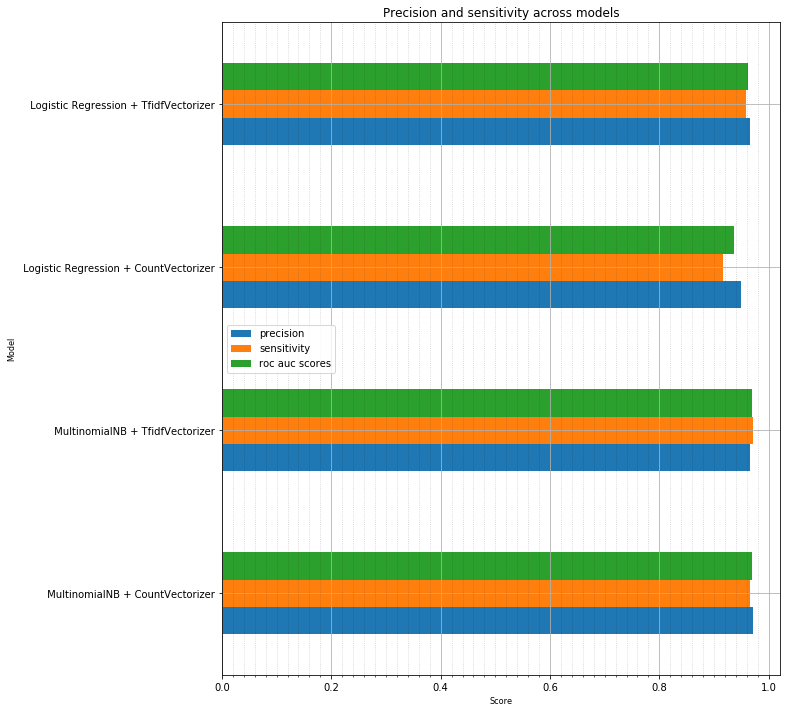

In [65]:
#plot barchart
ax = summary_scores[['precision','sensitivity','roc auc scores']].plot.barh(figsize = (10,12))
ax.set_title('Precision and sensitivity across models', fontsize = 12)
ax.set_xlabel('Score',fontsize = 8)
ax.set_ylabel('Model',fontsize = 8)
ax.legend(loc = 'center left')
ax.set_xticks((np.arange(0.0,1.0,0.02)),minor=True)
ax.set_yticks(range(len(summary_scores)))
ax.set_yticklabels(yticklabels)
ax.grid(True)
ax.grid(which='minor', color='k', linestyle=':', alpha=0.2);

**Observations**:

**Accuracy**

Logistic Regression generally has a higher accuracy score in training data than in validation data, indicating an overfit. 

Compared to Logistic Regression, Multinomial Naive Bayes has a lower difference in accuracy score between training data and validation data, indicating that the training model generalizes better for the validation data. Among the Multinomial Naive Bayes models, whether coupled with CountVectorizer or TFIDF Vectorizer, both have the same and highest accuracy scores.

**Precision, Sensitivity, ROC AUC Scores**

The model with the highest precision, sensitivity, and ROC AUC scores yet least difference between the two is Multinomial Naive Bayes with either our optimized TFIDF Vectorizer or Count Vectorizer. 

I will ultimately choose Multinomial Naive Bayes with TFIDF Vectorizer as the optimized transformer involved both unigrams and bigrams which will give a better context to the words.

## 4. Model Evaluation on Test Data

The selected vectorizer is Tfidf with params ('max_df': 0.9, 'max_features': 2000, 'min_df': 3, 'ngram_range': (1, 2), 'stop_words' = 'english').

The selected model is Multinomial Naive Bayes.

### 4.1 Fitting Model to Test Data

In [66]:
#instantiate vectorizer
tvec_op = TfidfVectorizer(max_df= 0.9, max_features= 2000, min_df= 3, ngram_range= (1, 2), stop_words ='english')

#fit_transform on the full training set
X_train_val_tvec = tvec_op.fit_transform(X_train_val)

X_test_tvec = tvec_op.transform(X_test)

In [67]:
#instantiate model
nb = MultinomialNB()

#fit all of the training data (including validation)
model = nb.fit(X_train_val_tvec,y_train_val)

### 4.2 Model Evaluation

In [68]:
#model score on full training data
train_score = model.score(X_train_val_tvec,y_train_val)
print(f'Accuracy of training data: {train_score}')

# model score on test data
test_score = model.score(X_test_tvec,y_test)
print(f'Accuracy of test data: {test_score}')
    
#Make predictions
predictions = model.predict(X_test_tvec)
    
#create confusion matrix
cm = confusion_matrix(y_test,predictions)
tn, fp, fn, tp = cm.ravel()
# confusion matrix to dataframe
cm_df = pd.DataFrame(cm, columns= ['Predict r/povertyfinance', 'Predict r/investing'], 
                         index=['Actual r/povertyfinance', 'Actual r/investing']) 

#precision score
precision = tp/(tp+fp)
print(f'Precision score of the model: {precision}')
    
#Sensitivity / Recall
sensitivity = tp/(tp+fn)
print(f'Sensitivity score of the model: {sensitivity}')

cm_df

Accuracy of training data: 0.9801587301587301
Accuracy of test data: 0.9735449735449735
Precision score of the model: 0.9775280898876404
Sensitivity score of the model: 0.9666666666666667


,Predict r/povertyfinance,Predict r/investing
Actual r/povertyfinance,194,4
Actual r/investing,6,174


**Observations**: The model is slightly overfitted to the training data, as we can see that there is a small decrease of accuracy score for the testing data. Nevertheless, precision and sensitivity scores are still high. 

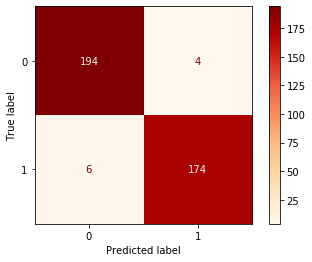

In [69]:
plot_confusion_matrix(model, X_test_tvec, y_test,
                      values_format = 'g',
                      cmap='OrRd');

**Observations**: The confusion matrix indicates that 4 posts that are r/povertyfinance have been misclassified as r/investing, 6 posts that are r/investing have been misclassified as r/povertyfinance.

In [70]:
#False Positives posts (predicted r/investing but is actually r/povertyfinance)

X_test[(predictions == 1) & (y_test == 0)]

159    index housing cost specifically look lowest priced option index housing cost specifically look lowest priced option wondering example much would room cheap apartment cost generally data cost living look bare essential rather average spending
166                                                                                                                                                                                                      ebay full depth drop shipping guide infographic
62                                                                                                                                                bank recommendation hi everyone looking leave pnc bad experience draft customer service recommendation
489                                                                                                                                                                                                                       free wendy piece nugget friday
Name

In [71]:
#False Negatives posts (predicted r/povertyfinance but is actually r/investing)

X_test[(predictions == 0) & (y_test == 1)]

1347                                                                                                                                                                                                                                                                                                                                                                              want invest recently interested investing stock market job money saved realize open account thought would parent create one would able add money threw found could affect financial aid college question severely affected able pull money parent information would help know else look
1786                                                                                                                                                                                                                                                                                                                    nj tax lien investing question recenel

**Observations**: Misclassifications happened when words used were more generic in nature, such as the word 'bank' which in r/povertyfinance may refer to bank recommendations and in r/investing may refer to performance of banking sector or 'index' in r/povertyfinance was a different context when in r/investing.  


In [72]:
pred_proba = [i[1] for i in nb.predict_proba(X_test_tvec)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

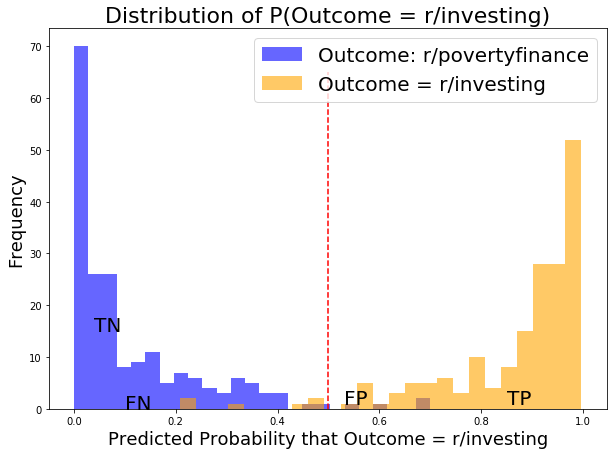

In [74]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome: r/povertyfinance')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = r/investing')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 15),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.2, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.85, 1),
             s = 'TP',
             size = 20)

plt.annotate(xy = (0.53, 1),
             s = 'FP',
             size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = r/investing)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = r/investing', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

**Observations**: The probabilty distribution for r/povertyfinance and r/investing shows that misclassifications happen when the probabilities overlap. Our threshold is at 0.5 between positive and negative class, as classifying posts into both subreddits are equally important.

In [75]:
#ROC and AUC score
roc_auc_score(pred_df['true_values'],pred_df['pred_probs'])

0.9954826038159372

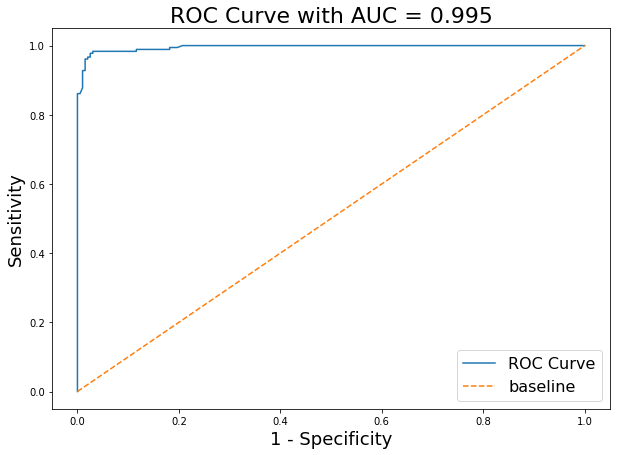

In [76]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

**Observations**: Sensitivity (true positive rate) plateaus at 0.995 (almost close to 1.0). AUC, the area between ROC curve and base line is almost close to 1.0, indicating good performance of the model at classifying the classes.

In [77]:
#Looking at top words

#coef for positive class

log_coef = model.coef_[0]
coef = np.exp(log_coef)

#getting the features 
features = tvec_op.get_feature_names()

#dataframe
features_prob = pd.DataFrame(coef,features).rename(columns = {0:'probability'})#ascending=False)

#top
pfin_top = features_prob.sort_values(by='probability',ascending=True).head(50)
investing_top = features_prob.sort_values(by='probability',ascending=False).head(50)

In [78]:
pfin_top.head(15)

,probability
egg,0.000189
dental,0.000189
deposit info,0.000189
deposit information,0.000189
deposited,0.000189
diagnosed,0.000189
paycheck paycheck,0.000189
direct deposit,0.000189
disability,0.000189
pay month,0.000189


In [79]:
investing_top.head(15)

,probability
stock,0.008430
company,0.005642
market,0.005604
investing,0.003518
amp,0.003478
earnings,0.003473
share,0.003306
like,0.003301
buy,0.003028
think,0.002971


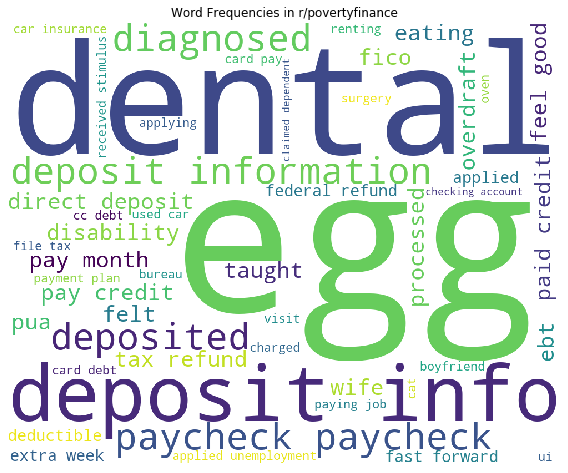

In [80]:
#wordcloud plot r/povertyfinance
pfin_wordcloud = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white').generate_from_frequencies(pfin_top['probability']); 
plt.figure(figsize=(8, 8))
plt.imshow(pfin_wordcloud)
plt.axis('off')
plt.title('Word Frequencies in r/povertyfinance')
plt.tight_layout();

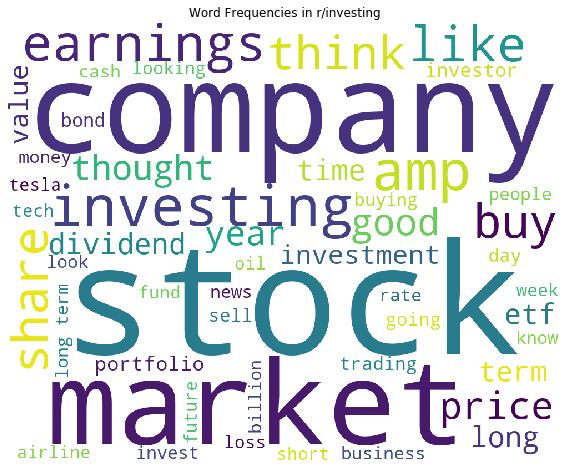

In [81]:
#wordcloud plot r/investing
investing_wordcloud = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white').generate_from_frequencies(investing_top['probability']); 
plt.figure(figsize=(8, 8))
plt.imshow(investing_wordcloud)
plt.axis('off')
plt.title('Word Frequencies in r/investing')
plt.tight_layout();

**Observations**:

In r/povertyfinance, topics center around egg (meal sharing / planning, groceries), dental, deposits, paychecks and debts.

In r/investing, topics center around stocks, market, company, investing, earnings. 

## 5. Conclusion and Recommendations

### Key Findings
Our final classifier model, Multinomial Naive Bayes with TFIDF Vectorizer,  was able to predict 97.4% of the posts in the test data accurately. It has a precision of 97.8% and sensitivity of 96.7%. 

Misclassifications happened when words used were more generic in nature, such as the word 'bank' which in r/povertyfinance may refer to bank recommendations and in r/investing may refer to performance of banking sector or 'index' in r/povertyfinance was a different context when in r/investing. Another example is ‘nugget’ referring to a gold nugget investing term, 'wendy' as a company in terms of share for r/investing. 


* Individuals can identify subreddits to explore based on the below:
    * Topics in r/povertyfinance center around **saving up and restricting spending for the financially challenged**. This includes money-saving tips / frugality (e.g. eggs as part of meals, groceries), basic needs (e.g. dental services), insurance advice, paying debts, and living paycheck to paycheck. 
    * Topics in r/investing center around **investing and making financial returns.** This includes stocks, market outlooks, discussions on companies, and earning potentials.

* Financial Advisors / Personal Finance Blogs / Websites: 
    * The model has been able to show what are the hot topics being discussed. 
    * The model can provide a quick overview to these blogs and websites to create more of such content, especially times-sensitive ones in order to improve engagement and visits. For example, in r/povertyfinance the word 'deposit' was commonly seen due to a recent stimulus check (or Econonomic Impact Payment) received by Americans under the Coronavirus Aid, Relief, and Economic Security (CARES) Act. https://smartasset.com/financial-advisor/coronavirus-stimulus-checks-how-much-will-you-get 
    * The model can provide insights to financial advisors on what their existing or potential clients would be interested in, to improve their advisory services to clients. For example, 'airline' and 'tesla' appear frequently in r/investing in recent posts. 


### Recommendations & Further Research
* Removal of noise words such as 'amp'. Increasing n-grams to get more context on more generic terms across subreddits.

* Explore other models and tools: Instead of classifying posts using frequency of words, we can consider using word similarities/analogies such as word2vec. We can also consider using stemming instead of lemmatizing for our words. We can also consider using other classifiers such as K-Nearest Neighbors classifier, Random Forests.

* Increase our training dataset in size and of a longer timeline: Our dataset contains only a small section of the subreddit over a short period of time and may not cover a good spectrum of content. We can also consider incorporating the comments section into our data for a larger corpus. 

* Explore relationships between content, number of comments, and upvote ratios.